### Generate Synthetic Data


In [1]:
import os
import json
import dotenv

from datasets import load_dataset, Dataset
from requests import ReadTimeout
from tqdm.auto import tqdm, trange

dotenv.load_dotenv()

def filecache(fn):
    filename = f".cache/{fn.__name__}.json"
    if not os.path.exists(".cache"):
        os.makedirs(".cache")

    if not os.path.exists(filename):
        with open(filename, "w") as f:
            json.dump({}, f)

    with open(filename, "r") as f:
        cache = json.load(f)

    def wrapped(*args, **kwargs):
        # if optimize is set to True, the function will be called without caching
        if kwargs.get('is_indeterministic', False):
            return fn(*args, **kwargs)
        
        key = str(list(map(str, args))) + json.dumps(kwargs, sort_keys=True)
        if key not in cache:
            res = fn(*args, **kwargs)
            cache[key] = res
            with open(filename, "w") as f:
                json.dump(cache, f)

        return cache[key]

    return wrapped


def ollama_generate(lm, prompt):
    temp = lm.timeout
    while True:
        try:
            res = lm.invoke(prompt)
            break
        except ReadTimeout:
            if lm.timeout > 120:
                print(f"Inference lasted for {lm.timeout} seconds. Stopping now.")
                break
            lm.timeout *= 2
            print(
                f"### ReadTimeout. Trying again with Timeout: {lm.timeout} seconds ###"
            )
        except Exception as e:
            print(f"### {e} ###")
            break
    lm.timeout = temp
    return res


class OPRO:
    def __str__(self):
        return "OPRO"

    def __init__(self, init):
        if "gemini" in init:
            import google.generativeai as genai

            genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

            self.gemini_model = genai.GenerativeModel(
                "gemini-pro",
                generation_config=genai.GenerationConfig(
                    temperature=0, max_output_tokens=2048
                ),
            )

        if "gemma" in init:
            from langchain_community.llms import Ollama

            self.gemma_model = Ollama(
                model="gemma:2b", temperature=0, num_gpu=40, timeout=30
            )

        if "anthropic" in init:
            import anthropic

            self.anthropic_client = anthropic.Anthropic()

    @filecache
    def generate(self, prompt, model="gemini", is_indeterministic=False):
        temperature = float(is_indeterministic)

        # gemini form
        if model == "gemini":
            return (
                self.gemini_model.generate_content(prompt, generation_config={"temperature": temperature})
                .candidates[0]
                .content.parts[0]
                .text
            )
        elif model == "gemma":
            self.gemma_model.temperature = temperature
            return ollama_generate(self.gemma_model, prompt)
        elif model == "anthropic":
            import anthropic

            try:
                return (
                    self.anthropic_client.messages.create(
                        model="claude-3-haiku-20240307",
                        max_tokens=200,
                        temperature=temperature,
                        messages=[{"role": "user", "content": prompt}],
                    )
                    .content[0]
                    .text
                )
            except anthropic.InternalServerError:
                return self.generate(prompt, model="anthropic")

        raise ValueError("Invalid synth value")


# load gsm8k dataset
gsm8k_dataset = load_dataset("gsm8k", "main")

opro = OPRO(["anthropic", "gemini", "gemma"])  # ["gemini", "gemma"]


# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic questions and answers to those questions similar to the gsm8k dataset.

Please generate a question and answer pair that is similar to the following question and answer pair as a JSON object:

{{
    "question": \"\"\"{question}\"\"\",
    "answer": \"\"\"{answer}\"\"\"
}}

Make sure the questions and answers are string values.
Take a deep breath and think step-by-step.
"""

    response = opro.generate(
        prompt_template.format(
            question=gsm8k_dataset["train"]["question"][0],
            answer=gsm8k_dataset["train"]["answer"][0],
        ),
        model="anthropic",  # gemini
        is_indeterministic=True,
    )
    return eval(response)


if not os.path.exists("synthetic_data.json"):
    qa_pairs = []
    SAMPLE_SIZE = 250

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except ReadTimeout:
            print("Read timeout error")
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open("synthetic_data.json", "w") as f:
        f.write(str(qa_pairs))
else:
    # Reading saved data
    with open("synthetic_data.json", "r") as f:
        qa_pairs = eval(f.read())

qa_pairs

[{'question': 'Ana invested \\$180 in a CD at 5% per year. How many years will it take the CD to double in value to \\$360, if interest is compounded annually?',
  'answer': 'Let x be the number of years it takes to double the value of the CD.\nAfter x years, the value of the CD will be 180*2 = 360.\nThe formula for compound interest is A = P*(1 + r/n)^(nt), where A is the final amount, P is the principal, r is the interest rate, n is the number of times per year that the interest is compounded, and t is the number of years.\nIn this case, r = 5, n = 1, and P = 180.\nSo, we have 360 = 180*(1 + 5/100)^(1*t).\nDividing both sides by 180, we get 2 = (1 + 5/100)^t.\nTaking the natural logarithm of both sides, we get ln(2) = t*ln(1 + 5/100).\nSolving for t, we get t = ln(2)/ln(1 + 5/100) = <<ln(2)/ln(1+5/100)=14>>14 years.\n#### 14'},
 {'question': 'Salma has a roll of ribbon that is 50 meters long. She uses 6 meters of the ribbon to wrap a present. What fraction of the ribbon roll has Salm

In [2]:
TRAINING_SAMPLE_SIZE = 30
TESTING_SAMPLE_SIZE = 50

training_sample = Dataset.from_dict(
    {
        "question": [pair["question"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "answer": [pair["answer"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "question": [
            pair["question"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "answer": [
            pair["answer"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["question"]), len(training_sample["answer"]), len(
    testing_sample["question"]
), len(testing_sample["answer"])

(30, 30, 50, 50)

### Optimize prompt on synthetic data


In [3]:
def opt_llm(instruction_score_pairs, training_sample):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

I have some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

The following exemplars show how to apply your text: you replace <INS> in each input with your
text, then read the input and give an output. We say your output is wrong if your output is different
from the given output, and we say your output is correct if they are the same.

input:
Q: {q1}
A: <INS>
output:
{a1}

input:
Q: {q2}
A: <INS>
output:
{a2}

input:
Q: {q3}
A: <INS>
output:
{a3}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""

    # Passing 20 Best Instruction-Score Pairs
    # 3 randomly chosen questions/answers from the training sample
    cut = lambda x: x.split("####")[-1].strip()
    q1, q2, q3 = (
        training_sample["question"][0],
        training_sample["question"][1],
        training_sample["question"][2],
    )
    a1, a2, a3 = (
        cut(training_sample["answer"][0]),
        cut(training_sample["answer"][1]),
        cut(training_sample["answer"][2]),
    )
    response = opro.generate(
        prompt.format(pairs_str=pairs_str, q1=q1, a1=a1, q2=q2, a2=a2, q3=q3, a3=a3),
        model="gemini",  # gemini
        is_indeterministic=True
    )
    return response


def score(instruction, sample):
    """
    Score the instruction using the sample. 
    
    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    prompt = """Q: {question}\nA: {instruction}"""
    with tqdm(sample, desc=instruction, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(question=sample_qa["question"], instruction=instruction),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += sample_qa["answer"].split("####")[-1].strip() in res
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [4]:
# Sample 3.5% of the training set
INS_PER_STEP = 8
EXEMPLARS_PER_STEP = 3
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_data_results_k.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        "Solve this problem",
        "Let's think step by step",
        "Let’s solve this problem by splitting it into steps",
        "Let’s think about this logically",
        "Take a deep breath and think through this",
        "Break this down",
        "Respond quickly",
        "a;lsdghougkaa;aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa",
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 10
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            exemplars = training_sample.shuffle()[:EXEMPLARS_PER_STEP]
            instructions = [
                opt_llm(ins_score_pairs, exemplars)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

In [5]:
ins_score_pairs

{"Let's analyze this in a comprehensive manner": 550.0,
 'Examine these lines systematically and consider the problem from every angle': 550.0,
 'Plan out the steps carefully': 450.0,
 'Let’s think about this methodically': 450.0,
 'Let’s solve this problem by splitting it into steps': 400.0,
 'Take some time to think about a strategy for this problem': 400.0,
 'Let’s think about this logically': 350.0,
 'Consider the problem by pieces': 350.0,
 "Let's think step by step": 300.0,
 'Let us think step-by-step': 300.0,
 'Solve.': 300.0,
 'Solve this problem': 250.0,
 'Take a deep breath and think through this': 200.0,
 'Break this down': 200.0,
 'Respond quickly': 200.0,
 'a;lsdghougkaa;aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': 100.0}

### Plotting Results and Testing Accuracy


Text(0.5, 1.0, 'Step to Accuracy')

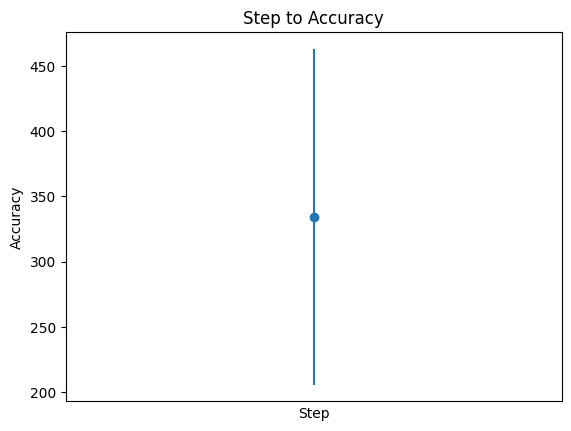

In [6]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [7]:
opro_results[str(len(opro_results))]

{"Let's analyze this in a comprehensive manner": 550.0,
 'Examine these lines systematically and consider the problem from every angle': 550.0,
 'Plan out the steps carefully': 450.0,
 'Let’s think about this methodically': 450.0,
 'Let’s solve this problem by splitting it into steps': 400.0,
 'Take some time to think about a strategy for this problem': 400.0,
 'Let’s think about this logically': 350.0,
 'Consider the problem by pieces': 350.0,
 "Let's think step by step": 300.0,
 'Let us think step-by-step': 300.0,
 'Solve.': 300.0,
 'Solve this problem': 250.0,
 'Take a deep breath and think through this': 200.0,
 'Break this down': 200.0,
 'Respond quickly': 200.0,
 'a;lsdghougkaa;aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': 100.0}

In [8]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print("No instruction: ", score("", testing_sample))
print(
    f"With best instruction ({best_instruction}): ",
    score(best_instruction, testing_sample),
)

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
data_original = Dataset.from_dict(gsm8k_dataset["test"][:250])
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print("No instruction: ", score("", data_original))
print(
    f"With best instruction ({best_instruction}): ",
    score(best_instruction, data_original),
)